<a href="https://colab.research.google.com/github/OlgaShishikina/kaggle/blob/main/Housing%20Prices%20Competition%20for%20Kaggle%20Learn%20Users/KaggleCatBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Предсказание цены дома

В данном блокноте будет рассмотрена задача машинного обучения с использованием набора данных, содержащих характеристики дома.

Это задача регрессионного машинного обучения с супервизией: при наличии набора данных с целевыми показателями (в данном случае оценка) мы хотим обучить модель, которая научится сопоставлять признаки с целевыми показателями.

## Описание проекта

## План проекта

Очистка и форматирование данных

Разведочный анализ данных

Feature engineering и отбор признаков

 Построение пайплайнна и сравнение нескольких моделей машинного обучения по метрике производительности

Настройку гиперпараметров лучшей модели, чтобы оптимизировать ее для решения задачи

Оцените лучшую модель на тестовом наборе

Интерпретируйте результаты модели, насколько это возможно.

Сделайте выводы и напишите хорошо документированный отчет




## Описание данных

 SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.

MSSubClass: The building class

MSZoning: The general zoning classification

LotFrontage: Linear feet of street connected to property

LotArea: Lot size in square feet

Street: Type of road access

Alley: Type of alley access

LotShape: General shape of property

LandContour: Flatness of the property

Utilities: Type of utilities available

LotConfig: Lot configuration

LandSlope: Slope of property

Neighborhood: Physical locations within Ames city limits

Condition1: Proximity to main road or railroad

Condition2: Proximity to main road or railroad (if a second is present)

BldgType: Type of dwelling

HouseStyle: Style of dwelling

OverallQual: Overall material and finish quality

OverallCond: Overall condition rating

YearBuilt: Original construction date

YearRemodAdd: Remodel date

RoofStyle: Type of roof

RoofMatl: Roof material

Exterior1st: Exterior covering on house

Exterior2nd: Exterior covering on house (if more than one material)

MasVnrType: Masonry veneer type

MasVnrArea: Masonry veneer area in square feet

ExterQual: Exterior material quality

ExterCond: Present condition of the material on the exterior

Foundation: Type of foundation

BsmtQual: Height of the basement

BsmtCond: General condition of the basement

BsmtExposure: Walkout or garden level basement walls

BsmtFinType1: Quality of basement finished area

BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Quality of second finished area (if present)

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

Heating: Type of heating

HeatingQC: Heating quality and condition

CentralAir: Central air conditioning

Electrical: Electrical system

1stFlrSF: First Floor square feet

2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

BsmtFullBath: Basement full bathrooms

BsmtHalfBath: Basement half bathrooms

FullBath: Full bathrooms above grade

HalfBath: Half baths above grade

Bedroom: Number of bedrooms above basement level

Kitchen: Number of kitchens

KitchenQual: Kitchen quality

TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)

Functional: Home functionality rating

Fireplaces: Number of fireplaces

FireplaceQu: Fireplace quality

GarageType: Garage location

GarageYrBlt: Year garage was built

GarageFinish: Interior finish of the garage

GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

GarageCond: Garage condition

PavedDrive: Paved driveway

WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

PoolArea: Pool area in square feet

PoolQC: Pool quality

Fence: Fence quality

MiscFeature: Miscellaneous feature not covered in other categories

MiscVal: $Value of miscellaneous feature

MoSold: Month Sold

YrSold: Year Sold

SaleType: Type of sale

SaleCondition: Condition of sale

## Установка недостающих библиотек



In [33]:
pip install phik -q

In [3]:
pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.2 MB/s eta 0:00:00


## Импорты

Мы будем использовать стандартные библиотеки для работы с данными и машинного обучения: numpy, pandas и scikit-learn. Также мы используем matplotlib и seaborn для визуализации.


In [4]:
# импорт библиотек
import pandas as pd
import time
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import  RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler,OneHotEncoder,LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score
)
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
# загружаем нужные классы
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# класс для работы с пропусками
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
import lightgbm as lgb
# отключаем предупреждения
import warnings
import re
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Функции

In [5]:
def missing_data (all_data):
  all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
  all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
  missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
  missing_data.head(30)

In [6]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [7]:
#Функции
def analyze_outliers(df, col):
  '''поиск выбросов с помощью IQR'''
  Q3 = np.quantile(df[col], 0.75, axis=0)
  Q1 = np.quantile(df[col], 0.25, axis=0)
  IQR = Q3 - Q1
  upper = round(Q3 + 1.5 * IQR, 2)
  lower = round(Q1 - 1.5 * IQR, 2)
  if round(Q1 - 1.5 * IQR, 2)<0:
    lower = 0
  print('____________________________________________________________________')
  print(f'интервал фактических значений для переменной {col} от {round(df[col].min(),2)} до {round(df[col].max(),2)}')
  print(f'интервал нормальных значений для переменной {col} от {lower} до {upper}')

  print(f'переменная {col} содержит аномальных значений : {round(df[(df[col]>upper)| (df[col]<lower)].shape[0]/df.shape[0]*100, 2)}%')



  return lower, upper

In [8]:
# функция для построения гистограммы и ящика с усами

def hist_box(data,col):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    #гистограмма
    sns.histplot(data = data, x = col, ax=axes[0], bins=50,kde=True)
    axes[0].set_title('гистограмма')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('колво')
    #ящик с усами
    sns.boxplot(data = data, x=col, ax=axes[1])
    axes[1].set_title('диаграмма размаха')
    fig.suptitle(col)
    plt.show()

In [9]:
# функция для построения графика для категориальных данных
def graf(data,col,label):
    print(data[col].value_counts())
    data[col].groupby(data[col]).count().plot(kind="pie",ylabel=label,fontsize=6);

In [10]:
def num_cat(df):
  numeric_features = df.select_dtypes(include=['float64', 'int64']).columns
  print('Числовые столбцы:',numeric_features)
  categorical_features = df.select_dtypes(include=['object']).columns
  print('Категориальные столбцы:',categorical_features)
  return numeric_features,categorical_features


In [11]:
# фиксируем константы
RANDOM_STATE = 91224

## Чтение данных

In [12]:
# чтение данных
try:
  train = pd.read_csv('train.csv')
  test = pd.read_csv('test.csv')
  print('load from current folder')
except:
  train = pd.read_csv('https://raw.githubusercontent.com/OlgaShishikina/kaggle/main/Housing%20Prices%20Competition%20for%20Kaggle%20Learn%20Users/train.csv')
  test = pd.read_csv('https://raw.githubusercontent.com/OlgaShishikina/kaggle/main/Housing%20Prices%20Competition%20for%20Kaggle%20Learn%20Users/test.csv')
  print('load from github')




load from github


In [13]:
# посмотрим на первые 5 строк трейн данных
display(train.head(5))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
# посмотрим на первые 5 строк тест данных
display(test.head(5))

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Уже видим проблемы, наблюдается много пропусков в некоторых столбцах.

In [15]:
# Размер датасета
print(f"В тренировочном датасете: {train.shape[0]} строк")

# Information about columns and data types
print(f"\n В датасете {train.shape[1]} столбцов, из них :")
print(train.dtypes.value_counts())

В тренировочном датасете: 1460 строк

 В датасете 81 столбцов, из них :
object     43
int64      35
float64     3
Name: count, dtype: int64


In [16]:
# Размер датасета
print(f"В тестовом датасете: {test.shape[0]} строк")

# Information about columns and data types
print(f"\n В датасете {test.shape[1]} столбцов, из них :")
print(test.dtypes.value_counts())

В тестовом датасете: 1459 строк

 В датасете 80 столбцов, из них :
object     43
int64      26
float64    11
Name: count, dtype: int64


Метод dataframe.info - это быстрый способ оценить данные, отобразив типы данных в каждом столбце и количество не пропущенных значе

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

Нужно проследить чтобы данные числового формата не имели тип строка, при необходимости корректируем тип данных.

**Вывод:**

я импортировала нужные библиотеки, прочла данные, ознакомилась с ними. Предстоит работа с двумя датасетами - тренировочном и тестовом данными

### таблица пропусков

Теперь, когда у нас есть правильные типы данных столбцов, мы можем начать анализ, посмотрев на процент пропущенных значений в каждом столбце.  для методов машинного обучения их придется заполнить.


In [19]:
missing_values_table(train)

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.


,Missing Values,% of Total Values
PoolQC,1453,99.5
MiscFeature,1406,96.3
Alley,1369,93.8
Fence,1179,80.8
MasVnrType,872,59.7
FireplaceQu,690,47.3
LotFrontage,259,17.7
GarageType,81,5.5
GarageYrBlt,81,5.5
GarageFinish,81,5.5


### вывод пропусков и их график

In [20]:
all_data_na = (train.isnull().sum() / len(train)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]


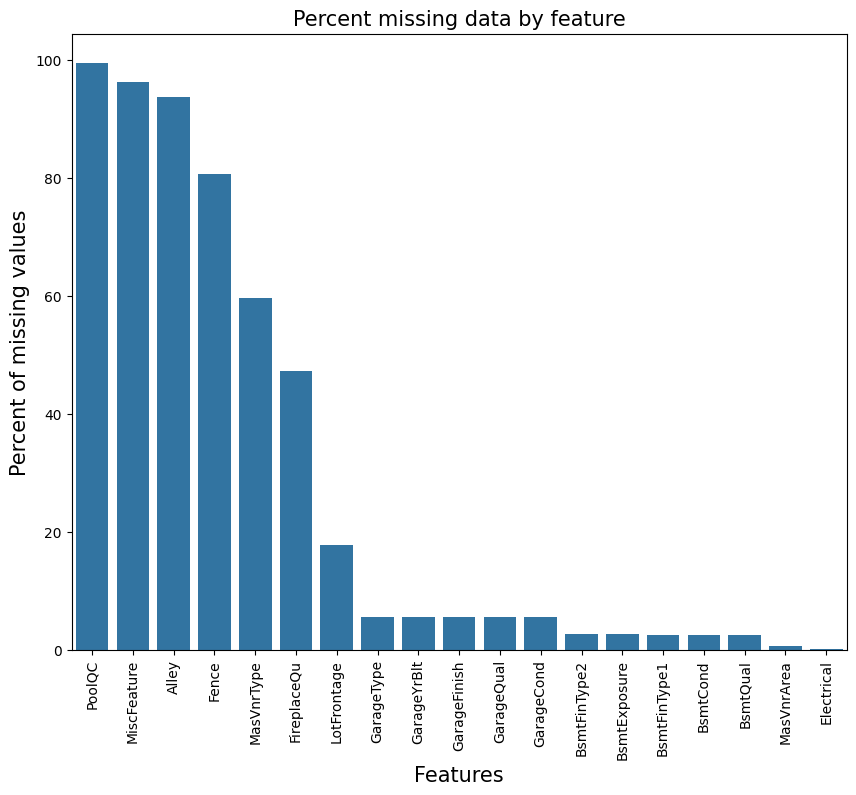

In [21]:
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15);

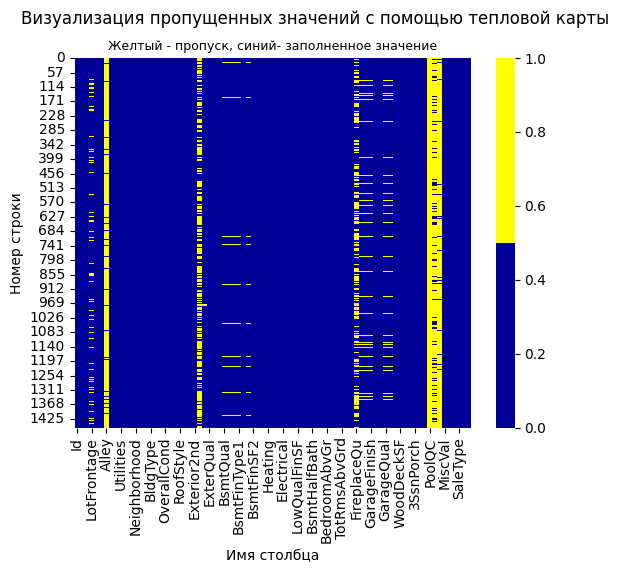

In [22]:
# визуализация пропущенных значений с помощью тепловой карты
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00']
sns.heatmap(train.isnull(), cmap=sns.color_palette(colours));
plt.suptitle('Визуализация пропущенных значений с помощью тепловой карты')
plt.title("Желтый - пропуск, синий- заполненное значение", fontsize =9);
plt.ylabel('Номер строки');
plt.xlabel('Имя столбца');

Хотя мы хотим не упустить информацию и должны быть осторожны при удалении столбцов, если столбец имеет высокий процент пропущенных значений, то он, вероятно, будет не очень полезен.

Выбор столбцов может быть несколько произвольным , но для данного проекта мы удалим все столбцы с более чем 80 % пропущенных значений. В целом, будьте осторожны, отбрасывая любую информацию, потому что даже если ее нет во всех наблюдениях, она все равно может быть полезна для прогнозирования целевого значения.

In [23]:
# Get the columns with > 80% missing
missing_df = missing_values_table(train)
missing_columns = list(missing_df[missing_df['% of Total Values'] > 80].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 81 columns.
There are 19 columns that have missing values.
We will remove 4 columns.


In [24]:
# Drop the columns
#train = train.drop(columns = list(missing_columns))

In [25]:
missing_columns

['PoolQC', 'MiscFeature', 'Alley', 'Fence']

Остальные недостающие значения придется заполнять с помощью соответствующей стратегии, прежде чем приступать к машинному обучению.


In [26]:
numeric_features,categorical_features =  num_cat(train)

Числовые столбцы: Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Категориальные столбцы: Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinT

In [27]:
for col in numeric_features:
  analyze_outliers(train, col)

____________________________________________________________________
интервал фактических значений для переменной Id от 1 до 1460
интервал нормальных значений для переменной Id от 0 до 2189.5
переменная Id содержит аномальных значений : 0.0%
____________________________________________________________________
интервал фактических значений для переменной MSSubClass от 20 до 190
интервал нормальных значений для переменной MSSubClass от 0 до 145.0
переменная MSSubClass содержит аномальных значений : 7.05%
____________________________________________________________________
интервал фактических значений для переменной LotFrontage от 21.0 до 313.0
интервал нормальных значений для переменной LotFrontage от nan до nan
переменная LotFrontage содержит аномальных значений : 0.0%
____________________________________________________________________
интервал фактических значений для переменной LotArea от 1300 до 215245
интервал нормальных значений для переменной LotArea от 1481.5 до 17673.5
перемен

## Исследовательский анализ данных  EDA

(EDA) - это открытый процесс, в ходе которого мы строим графики и подсчитываем статистику, чтобы изучить наши данные. Цель - найти аномалии, закономерности, тенденции или взаимосвязи. Они могут быть интересны сами по себе (например, обнаружение корреляции между двумя переменными) или использоваться для обоснования решений по моделированию, например, о том, какие функции использовать. Короче говоря, цель EDA - определить, что могут рассказать нам наши данные! Обычно EDA начинается с высокоуровневого обзора, а затем, по мере нахождения интересных областей для изучения, сужается до конкретных частей набора данных.

Чтобы начать EDA, мы сосредоточимся на одной переменной - SalePrice, поскольку именно она является целью для наших моделей машинного обучения.

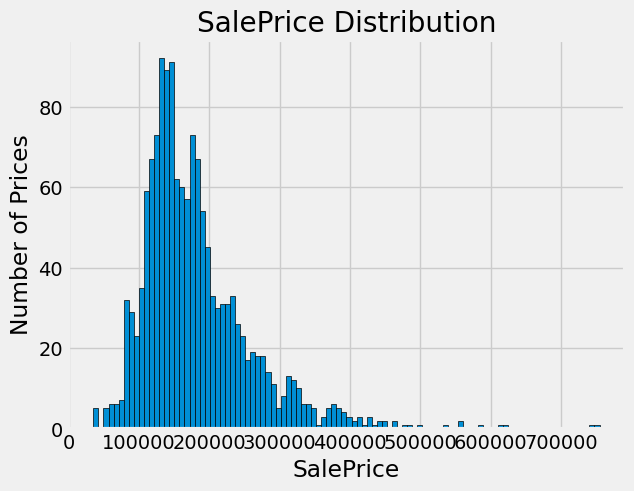

In [28]:



# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train['SalePrice'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('SalePrice'); plt.ylabel('Number of Prices');
plt.title('SalePrice Distribution');

Распределение нормальное, скошено вправо

### Удаление выбросов

Когда мы удаляем выбросы, мы должны быть уверены, что не отбрасываем измерения только потому, что они выглядят странно. Они могут быть результатом реального явления, которое нам следует изучить. При удалении выбросов я стараюсь быть как можно более консервативным, используя определение экстремального выброса:

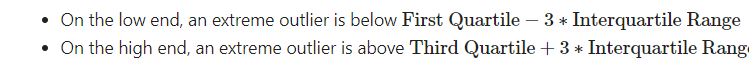

В данном случае я удалю только одну точку с экстремальным значением и посмотрю, как будет выглядеть распределение.

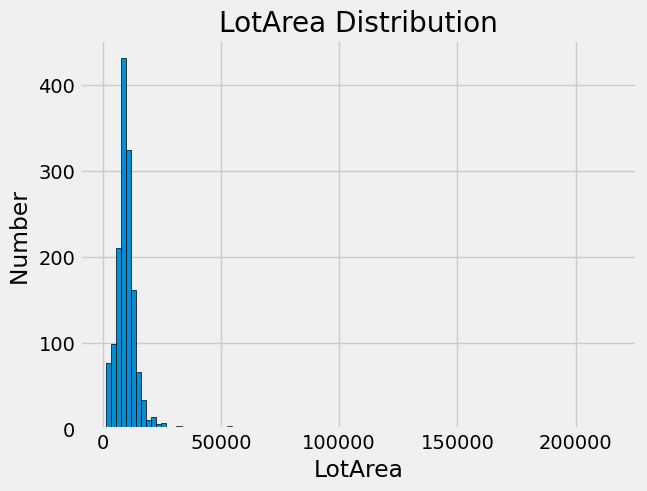

In [29]:
# Histogram of the Energy Star Score
plt.style.use('fivethirtyeight')
plt.hist(train['LotArea'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('LotArea');
plt.ylabel('Number ');
plt.title('LotArea Distribution');


In [30]:
# Calculate first and third quartile
first_quartile = train['LotArea'].describe()['25%']
third_quartile = train['LotArea'].describe()['75%']

# Interquartile range
iqr = third_quartile - first_quartile

# Remove outliers
train = train[(train['LotArea']> (first_quartile - 3 * iqr)) &
            (train['LotArea'] < (third_quartile + 3 * iqr))]

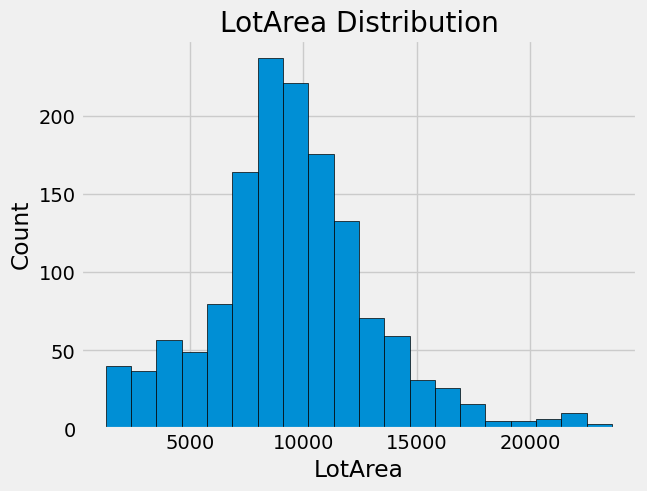

In [31]:
# Histogram Plot of Site EUI

plt.hist(train['LotArea'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('LotArea');
plt.ylabel('Count'); plt.title('LotArea Distribution');

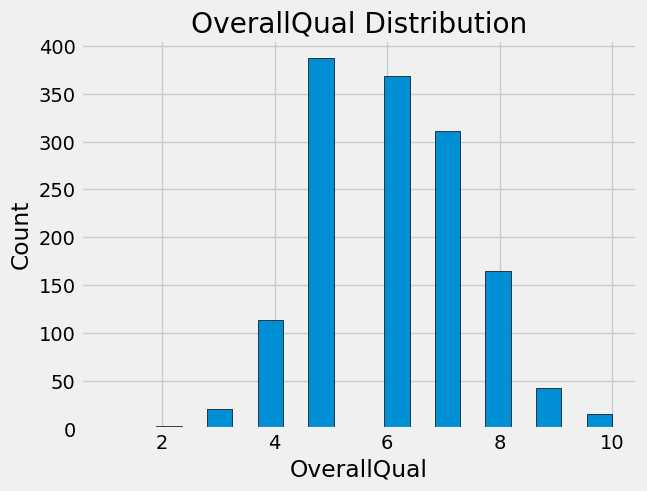

In [32]:

# Histogram Plot of Site EUI

plt.hist(train['OverallQual'].dropna(), bins = 20, edgecolor = 'black');
plt.xlabel('OverallQual');
plt.ylabel('Count'); plt.title('OverallQual Distribution');

Удалив выбросы, мы можем вернуться к анализу.

Этот график выглядит немного менее подозрительно и близок к нормальному распределению с длинным хвостом в правой части (у него положительный перекос).

In [35]:
train = train.drop(train[(train['1stFlrSF'] > 3000)
                                  & (train['SalePrice'] < 200000)].index)
train = train.drop(train[(train['GrLivArea'] > 3000)
                                  & (train['SalePrice'] < 300000)].index)
train = train.drop(train[(train['GarageArea'] > 1200)
                                  & (train['SalePrice'] < 300000)].index)
train = train.drop(train[(train['TotalBsmtSF'] > 4000)
                                  & (train['SalePrice'] < 200000)].index)
train = train.drop(train[(train['TotRmsAbvGrd'] >13)
                                  & (train['SalePrice'] < 250000)].index)

### Поиск взаимосвязей

Чтобы посмотреть на влияние категориальных переменных на оценку, мы можем построить график плотности, окрашенный по значению категориальной переменной. Графики плотности также показывают распределение одной переменной и могут рассматриваться как сглаженная гистограмма. Если мы раскрасим кривые плотности по категориальной переменной, это покажет нам, как меняется распределение в зависимости от класса.

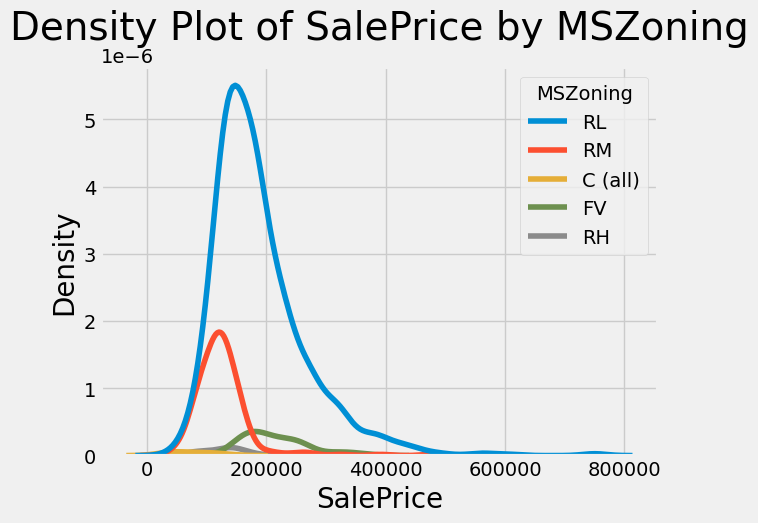

In [36]:
sns.kdeplot(data=train, x='SalePrice', hue='MSZoning')
plt.title('Density Plot of SalePrice by MSZoning', size = 28);
plt.xlabel('SalePrice', size = 20); plt.ylabel('Density', size = 20);
plt.show()
# label the plot

### Корреляции между признаками и таргетом

Приведенный ниже код вычисляет коэффициенты корреляции между всеми переменными и ценой дома.


In [37]:
# Find all correlations and sort
correlations_data = train.corr(numeric_only=True)['SalePrice'].sort_values()

# Print the most negative correlations
print(correlations_data.head(15), '\n')

# Print the most positive correlations
print(correlations_data.tail(15))

KitchenAbvGr    -0.138962
EnclosedPorch   -0.137566
MSSubClass      -0.084968
OverallCond     -0.084209
LowQualFinSF    -0.037576
YrSold          -0.028641
BsmtFinSF2      -0.022462
MiscVal         -0.020559
BsmtHalfBath    -0.018995
Id              -0.015339
MoSold           0.045217
3SsnPorch        0.048604
PoolArea         0.104134
ScreenPorch      0.109288
BedroomAbvGr     0.166103
Name: SalePrice, dtype: float64 

LotArea         0.425628
Fireplaces      0.469271
MasVnrArea      0.470642
GarageYrBlt     0.507443
YearRemodAdd    0.519363
TotRmsAbvGrd    0.542431
YearBuilt       0.543139
FullBath        0.567080
1stFlrSF        0.634690
GarageArea      0.649713
GarageCars      0.652090
TotalBsmtSF     0.652209
GrLivArea       0.737370
OverallQual     0.802672
SalePrice       1.000000
Name: SalePrice, dtype: float64


In [38]:
# Create a list of buildings with more than 100 measurements
types = train.dropna(subset=['SalePrice'])
types = types['MSZoning'].value_counts()
types = list(types[types.values > 100].index)

Существует несколько сильных отрицательных корреляций между характеристиками и целевым показателем. Наиболее отрицательно коррелируют с показателем EnclosedPorch и KitchenAbvGr

## Подготовка данных

In [39]:
# Separate target variable and features
y = train['SalePrice']
X = train.drop(columns=['SalePrice', 'Id'])
test_ids = test['Id']
test.drop(columns=['Id'], inplace=True)

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

In [40]:
cols_to_drop = ["Alley", "FireplaceQu", "PoolQC", "Fence", "MiscFeature"]
train.drop(columns=cols_to_drop, inplace=True)
test.drop(columns=cols_to_drop, inplace=True)

# Fill missing values
for df in [train, test]:
   # Numerical columns
   num_cols = df.select_dtypes(include=["float64", "int64"]).columns
   df[num_cols] = df[num_cols].fillna(df[num_cols].median())

   # Categorical columns
   cat_cols = df.select_dtypes(include=["object"]).columns
   df[cat_cols] = df[cat_cols].fillna("NA")

In [41]:
# Identify categorical and numerical columns
X.drop(columns=cols_to_drop, inplace=True)
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

### Разбивка на фичи и таргет





In [42]:
y = train['SalePrice']
X = train.drop(columns=['SalePrice', 'Id'])

### Разбивка данных на тест и валид

In [43]:
# Split the training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature engineering

#### train

In [44]:

X_train['Exterior'] = X_train['Exterior1st']+X_train['Exterior2nd']
X_train = X_train.drop(columns=['Exterior2nd', 'Exterior1st'])

In [45]:
X_train['Condition'] = X_train['Condition1']+X_train['Condition2']
X_train = X_train.drop(columns=['Condition1', 'Condition2'])

#### val

In [46]:
X_val.Condition1

,Condition1
51,Norm
294,Norm
696,Norm
1033,Norm
375,Norm
...,...
1327,Norm
359,Norm
1336,Feedr
1450,Norm


In [47]:

X_val['Exterior'] = X_val['Exterior1st']+X_val['Exterior2nd']
X_val = X_val.drop(columns=['Exterior2nd', 'Exterior1st'])
X_val['Condition'] = X_val['Condition1']+X_val['Condition2']
X_val = X_val.drop(columns=['Condition1', 'Condition2'])

#### test

In [48]:
test['Exterior'] = test['Exterior1st']+test['Exterior2nd']
test = test.drop(columns=['Exterior2nd', 'Exterior1st'])

In [49]:
test['Condition'] = test['Condition1']+test['Condition2']
test = test.drop(columns=['Condition1', 'Condition2'])

### Категориальные и числовые столбцы

In [50]:
categorical_cols = X_train.select_dtypes(include=['object']).columns
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

###  SimpleImputer + OHE

In [51]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
)

### ColumnTransformer

In [52]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [

        ('ohe', ohe_pipe, categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

### Pipeline

In [53]:
# итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=12345))
    ]
)

### param_distributions

In [54]:
# убирает выводы при обучении модели verbose=False
param_distributions = [

    {
        'models': [CatBoostRegressor(task_type="GPU",verbose=False)],
        'models__learning_rate':(0.1,1),
        'models__max_depth': range(2, 8, 2),
        'models__n_estimators':range(200,800,200)

    }

]

### GridSearchCV

In [56]:
grid = GridSearchCV(
    pipe_final,
    param_grid=param_distributions,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs = -1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighbor...
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object'))])),
                                       ('models',
                                        DecisionTreeRegressor(random_state=12345))]),
             n_jobs=-1,
             param_grid=[{'models': [<catboost.core.CatBoostRegressor object at 0x7fbdcc183c10>],
                          'models__learning_rate': (0.1, 1),
                          'models__max_depth': range(2, 8, 2),
                          'models__n_estimators': range(200, 800, 200)}],
             scoring='neg_mean_absolute_error')

In [57]:

print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle...
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'Gara

### Валидационный датасет

In [58]:
model = grid.best_estimator_
y_pred = model.predict(X_val)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [59]:
mae = mean_absolute_error(y_val,y_pred) *(-1)
mae

-13178.74759755094

### Тестовый датасет

In [60]:

y_pred = model.predict(test)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 4, 25, 26, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [61]:
predictions = pd.DataFrame()

In [62]:
predictions['Id'] = test_ids

In [63]:
predictions['SalePrice'] = y_pred

In [64]:
predictions.shape

(1459, 2)

In [65]:
predictions.to_csv('out.csv',index=False)

## Результаты

на момент сдачи удалось добиться 56 места

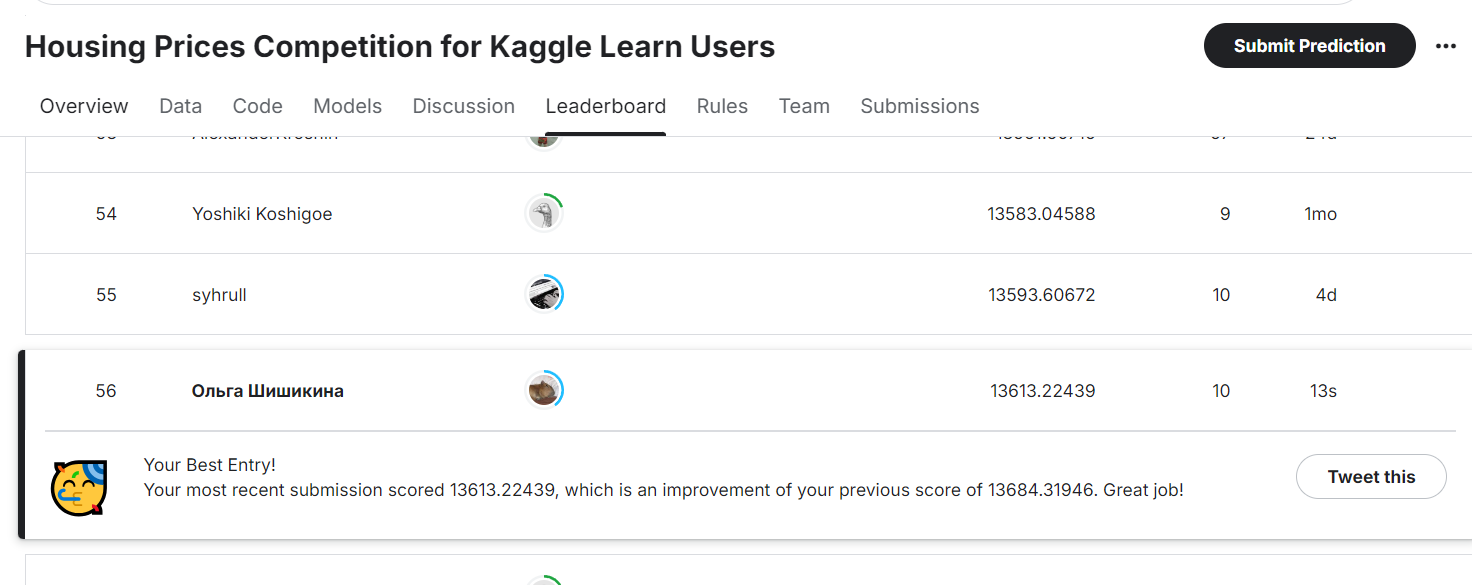

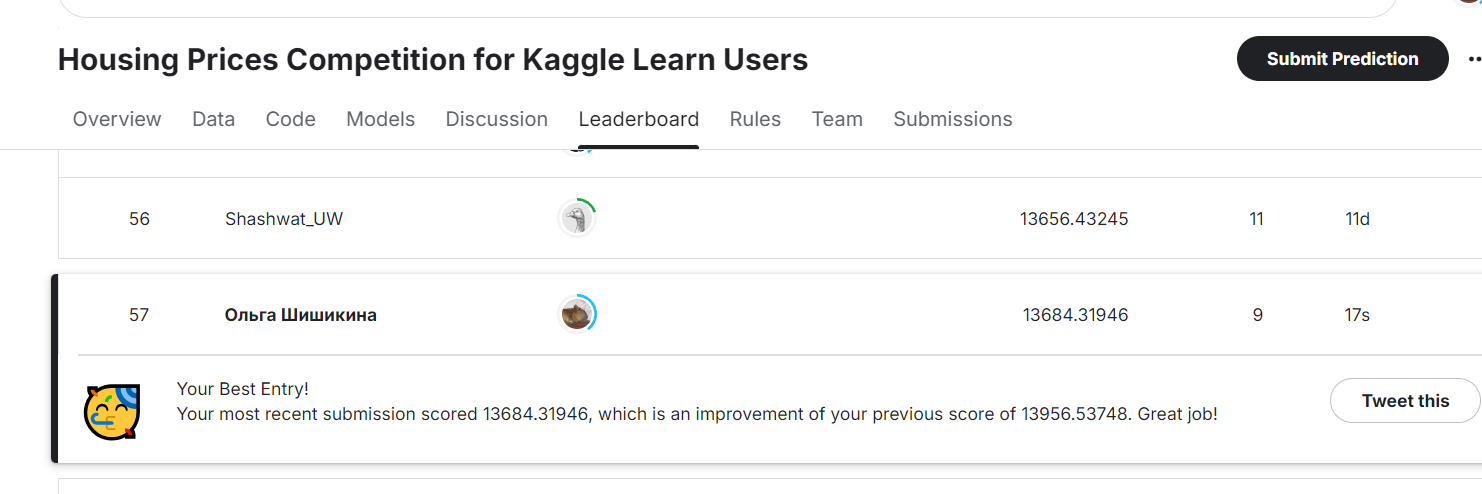